# LiDAR 101

## Create and visualize a TileDB sparse array from a LiDAR LAZ file

*Last updated: 7 May 2021*

A point cloud is a set of points in space representing a 3D shape or object. Each point is described by it's coordinates [X, Y, Z] and attribute-fields. A point cloud can be stored as a TileDB sparse array. 

LiDAR(Light Detection and Ranging) data is a point cloud of massive dimensions of millions, and even up to trillions of points. The coordinates and attributes of the points are measured by targeting an object with a laser and measuring the time for the reflected light to return to the receiver. For the data in this tutorial this is done from helicopters and planes, but this technology is also used for autonomous cars and navigation.

In this notebook you will:

* Create a TileDB sparse array by ingesting data from a LiDAR LAZ file 
* Slice and load data from the sparse array with numpy
* Explore and visualise a slice of the data with pandas
* Visualise a 3D point cloud  

### Import packages

In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pdal
import tiledb
import pyarrow

%matplotlib inline

<a id = data> </a>
## 2. Download Data

This tutorial uses data from the **Actueel Hoogtebestand Nederland** ([AHN](https://www.ahn.nl)), an elevation dataset that covers all of the Netherlands. From this dataset both raster and point cloud data can be [downloaded](https://downloads.pdok.nl/ahn3-downloadpage/) by selecting a tile an interactive map. Choose one of the below options to download a single LAZ file containing the point cloud data:

* Manually download one LAZ file
* Use the command line and run: \
    `wget "https://download.pdok.nl/rws/ahn3/v1_0/laz/C_38EZ2.LAZ"`
* Run the below cell 

In [2]:
!wget -N "https://download.pdok.nl/rws/ahn3/v1_0/laz/C_38EZ2.LAZ"

--2021-05-07 13:27:03--  https://download.pdok.nl/rws/ahn3/v1_0/laz/C_38EZ2.LAZ
Resolving download.pdok.nl (download.pdok.nl)... 51.138.23.105
Connecting to download.pdok.nl (download.pdok.nl)|51.138.23.105|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘C_38EZ2.LAZ’ not modified on server. Omitting download.



To check if the the file exists print the size of the file. If this gives you a size of 0 GB or an error, try downloading the file again.

In [3]:
las_file = "C_38EZ2.LAZ"

print('File size: ' + str(round(os.path.getsize(las_file) / (1024 * 1024 * 1024), 3)) + ' GB')

File size: 1.685 GB


<a id = create> </a>
## 3. Create a LiDAR sparse array

### PDAL pipeline

The conversion is done with a PDAL pipeline that you can find in `pipeline.json`:

```json
[
    {
      "type":"readers.las",
      "filename":"C_38EZ2.LAZ"
    },
    {
      "type":"writers.tiledb",
      "chunk_size": 1000000,
      "array_name":"ahn"
    }
]
```

Find more info in the PDAL documentation on [readers.las](https://pdal.io/stages/readers.las.html) and [writers.tiledb](https://pdal.io/stages/writers.tiledb.html).

Before running the conversion, update the `filename` and `array_name` with the correct path. 

In [4]:
with open('pipeline.json', 'r') as file:
    pipeline=file.read()

json.loads(pipeline)

[{'type': 'readers.las', 'filename': 'C_38EZ2.LAZ'},
 {'type': 'writers.tiledb', 'chunk_size': 1000000, 'array_name': 'ahn'}]

### Create the array

Now create the TileDB sparse array by converting the data from the LAZ file:

In [5]:
%%time
!pdal pipeline -i pipeline.json

PDAL: writers.tiledb: Array already exists.

CPU times: user 2.58 ms, sys: 5.19 ms, total: 7.77 ms
Wall time: 187 ms


<a id = examine> </a>
## 4. Is the conversion successful?

A few checks to make sure all data from the LAZ file is converted to the sparse array.

### Dimensions and attributes

Find the dimensions and attributes of the LAZ file in the schema. Access the LAZ schema with [`pdal info`](https://pdal.io/apps/info.html) and add `| jq '.schema'` to return only the part that you are interested in: 

In [6]:
las_schema = !pdal info {las_file} --schema | jq '.schema'
las_schema

['{',
 '  "dimensions": [',
 '    {',
 '      "name": "X",',
 '      "size": 8,',
 '      "type": "floating"',
 '    },',
 '    {',
 '      "name": "Y",',
 '      "size": 8,',
 '      "type": "floating"',
 '    },',
 '    {',
 '      "name": "Z",',
 '      "size": 8,',
 '      "type": "floating"',
 '    },',
 '    {',
 '      "name": "Intensity",',
 '      "size": 2,',
 '      "type": "unsigned"',
 '    },',
 '    {',
 '      "name": "ReturnNumber",',
 '      "size": 1,',
 '      "type": "unsigned"',
 '    },',
 '    {',
 '      "name": "NumberOfReturns",',
 '      "size": 1,',
 '      "type": "unsigned"',
 '    },',
 '    {',
 '      "name": "ScanDirectionFlag",',
 '      "size": 1,',
 '      "type": "unsigned"',
 '    },',
 '    {',
 '      "name": "EdgeOfFlightLine",',
 '      "size": 1,',
 '      "type": "unsigned"',
 '    },',
 '    {',
 '      "name": "Classification",',
 '      "size": 1,',
 '      "type": "unsigned"',
 '    },',
 '    {',
 '      "name": "ScanAngleRank",',
 '  

The number of dimensions and attributes should be the same in the LAZ file and the sparse array. Find the dimensions and attributes of the array in the [schema](https://docs.tiledb.com/main/solutions/tiledb-embedded/api-usage/reading-arrays/reading-the-array-schema). 

> More information about the data model of sparse arrays is [here](https://docs.tiledb.com/main/basic-concepts/data-model).

In [7]:
array_name = "ahn"

schema = tiledb.ArraySchema.load(array_name)
print(schema.sparse)

True


The [domain](https://docs.tiledb.com/main/solutions/tiledb-embedded/api-usage/reading-arrays/reading-the-array-schema#inspecting-domain) describes the multi-dimensional space of the cells:

In [8]:
domain = schema.domain

print('Number of dimensions: ' + str(domain.ndim))
print(domain)

Number of dimensions: 3
Domain(Dim(name='X', domain=(-1.7976931348623157e+308, 1.7976931348623157e+308), tile=1000.0, dtype='float64'),
       Dim(name='Y', domain=(-1.7976931348623157e+308, 1.7976931348623157e+308), tile=1000.0, dtype='float64'),
       Dim(name='Z', domain=(-1.7976931348623157e+308, 1.7976931348623157e+308), tile=1000.0, dtype='float64'))


The sparse array has 10 attributes: 

In [9]:
print('Number of attributes: ' + str(schema.nattr))

for i in range(schema.nattr):
    print(schema.attr(i))

Number of attributes: 10
Attr(name='Intensity', dtype='uint16', var=False, nullable=False, filters=FilterList([Bzip2Filter(level=5), ]))
Attr(name='ReturnNumber', dtype='uint8', var=False, nullable=False, filters=FilterList([ZstdFilter(level=7), ]))
Attr(name='NumberOfReturns', dtype='uint8', var=False, nullable=False, filters=FilterList([ZstdFilter(level=7), ]))
Attr(name='ScanDirectionFlag', dtype='uint8', var=False, nullable=False, filters=FilterList([Bzip2Filter(level=5), ]))
Attr(name='EdgeOfFlightLine', dtype='uint8', var=False, nullable=False, filters=FilterList([Bzip2Filter(level=5), ]))
Attr(name='Classification', dtype='uint8', var=False, nullable=False, filters=FilterList([GzipFilter(level=9), ]))
Attr(name='ScanAngleRank', dtype='float32', var=False, nullable=False, filters=FilterList([Bzip2Filter(level=5), ]))
Attr(name='UserData', dtype='uint8', var=False, nullable=False, filters=FilterList([GzipFilter(level=9), ]))
Attr(name='PointSourceId', dtype='uint16', var=False, nu

### Total number of points

To make sure that all points are converted to the sparse array, count and compare the total number of points.

In [10]:
%%time
with tiledb.open(array_name, mode='r') as arr:
    points = arr.df[:,:,:]

CPU times: user 2min 50s, sys: 2min 26s, total: 5min 17s
Wall time: 1min 47s


In [11]:
las_points = !pdal info {las_file} --metadata | jq '.metadata .count'

In [12]:
print('Points in LAZ file: ' + str(las_points))
print('Points in sparse array: ' + str(len(points['X'])))

Points in LAZ file: ['441136387']
Points in sparse array: 441136387


<a id = what> </a>
## 5. What is in the TileDB sparse array?

You now have successfully created a sparse array of a LiDAR point cloud! But what data is inside?

### Slice

Let's explore the sparse array with loading a small slice of the dataset into a [Pandas DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html):

In [13]:
%%time
with tiledb.open(array_name) as arr:
    df = pd.DataFrame(arr[125600:126000,  440900:441300, :])

df.head()

CPU times: user 1.3 s, sys: 793 ms, total: 2.1 s
Wall time: 561 ms


,Intensity,ReturnNumber,NumberOfReturns,ScanDirectionFlag,EdgeOfFlightLine,Classification,ScanAngleRank,UserData,PointSourceId,GpsTime,X,Y,Z
0,156,1,1,0,1,2,30.0,2,63,1.025990e+08,125765.220,440926.423,0.370
1,84,1,1,0,1,1,30.0,2,63,1.025990e+08,125765.457,440925.949,0.541
2,35,1,1,0,1,2,30.0,2,63,1.025990e+08,125765.512,440926.934,0.387
3,82,1,1,0,1,2,30.0,2,63,1.025990e+08,125765.517,440927.536,0.384
4,103,1,1,0,0,2,30.0,2,63,1.025990e+08,125765.573,440926.203,0.376


### Explore

Generate descriptive statistics for the DataFrame with [`describe()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html) and addto make the table easier to read: `transpose()` to make the table easier to read:

In [14]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Intensity,1638863.0,1.441129e+02,191.501496,1.000000e+00,7.300000e+01,1.330000e+02,1.890000e+02,6.553300e+04
ReturnNumber,1638863.0,1.147200e+00,0.484974,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,5.000000e+00
NumberOfReturns,1638863.0,1.294709e+00,0.733080,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,5.000000e+00
ScanDirectionFlag,1638863.0,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
EdgeOfFlightLine,1638863.0,1.668230e-03,0.040810,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
Classification,1638863.0,2.990525e+00,2.084603,1.000000e+00,2.000000e+00,2.000000e+00,6.000000e+00,2.600000e+01
ScanAngleRank,1638863.0,1.022864e+01,14.298751,-3.500000e+01,1.000000e+00,1.300000e+01,2.200000e+01,3.100000e+01
UserData,1638863.0,2.000000e+00,0.000000,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00
PointSourceId,1638863.0,6.372811e+01,0.511710,6.300000e+01,6.300000e+01,6.400000e+01,6.400000e+01,6.500000e+01
GpsTime,1638863.0,1.025998e+08,557.061087,1.025990e+08,1.025990e+08,1.026002e+08,1.026002e+08,1.026005e+08


### Outliers

From the above table you can see that the `max` of `Intensity` is two magnitudes larger than the `mean`. For all other attributes the values are much closer. Check for outliers with a histogram:

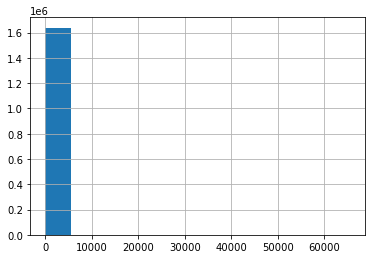

In [15]:
df['Intensity'].hist(bins=12);

Almost all points have a value for `Intensity` < 1000. It seems valid to assume that higher values are outliers. Calculate and print the percentage of points that are larger than 1000, delete these outliers from the DataFrame and create a new histogram with the remaining points:

0.13375126535897144 %


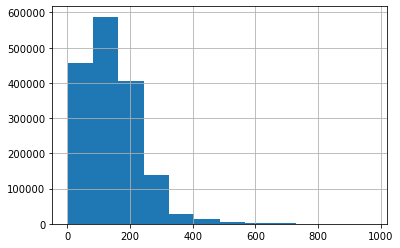

In [16]:
print(str(df['Intensity'][df['Intensity']>1e3].count()/df['Intensity'].count()*100) + ' %')

df = df.drop(df[df['Intensity']>1e3].index) 

df['Intensity'].hist(bins=12);

### Visualise a point cloud

By removing the outliers you can now make sure that the color scale in the below data visualisations is correct. Create a 2D scatter plot where the colorscale is the `Intensity`:

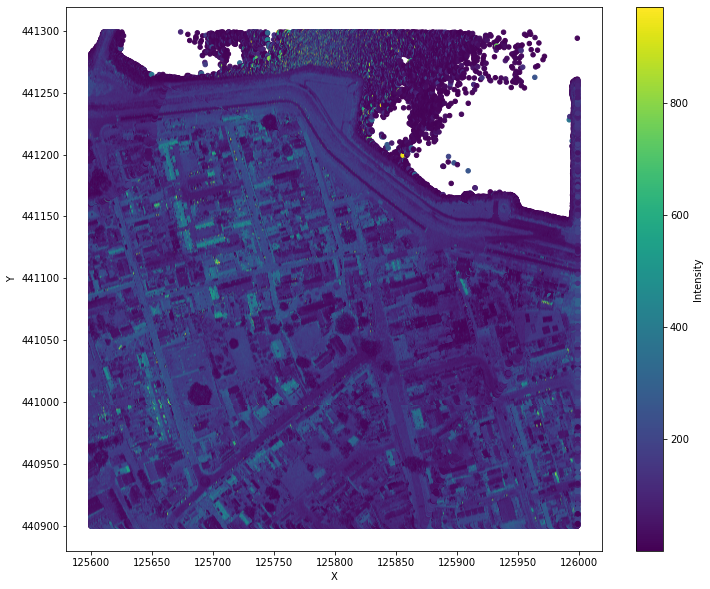

In [17]:
fig = plt.figure(figsize=(12, 10));
ax = fig.add_subplot(111)

df.plot.scatter(ax=ax,x='X',y='Y',c='Intensity',colormap='viridis');

This area is a bit too large for a static 3D plot. Load the data for a smaller area and then visualise the data as a 3D point cloud. 

Recognise the [building](https://www.ameide-tienhoven.nl/wp-content/uploads/2014/02/stadhuis-Ameide.jpg)?

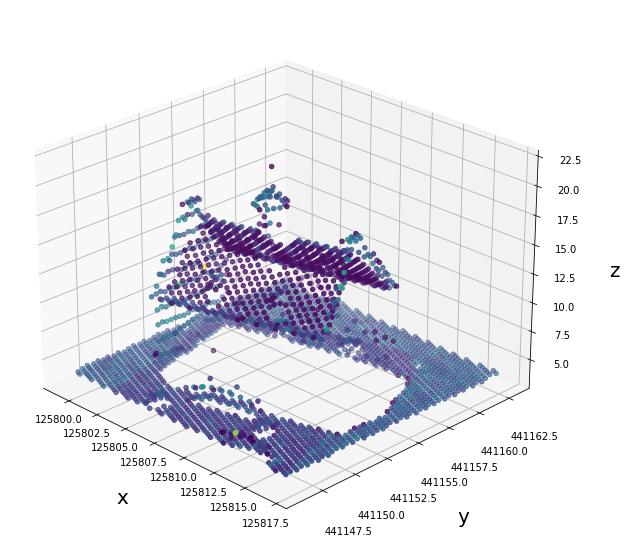

In [18]:
with tiledb.open(array_name, mode='r') as arr:
     points2 = arr.multi_index[125799:125817, 441146:441163, :]
    
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.ticklabel_format(useOffset=False)

ax.scatter(points2['X'], points2['Y'], points2['Z'], c=points2['Intensity'])

ax.set_xlabel('x', fontsize=20, labelpad=20)
ax.set_ylabel('y', fontsize=20, labelpad=35)
ax.set_zlabel('z', fontsize=20, labelpad=25)
ax.view_init(25, -45)
ax.tick_params(axis='y', pad=20)
ax.tick_params(axis='z', pad=10)
plt.show()

Or plot a [triangulated surface](https://matplotlib.org/stable/tutorials/toolkits/mplot3d.html?highlight=trisurf#mpl_toolkits.mplot3d.Axes3D.plot_trisurf):

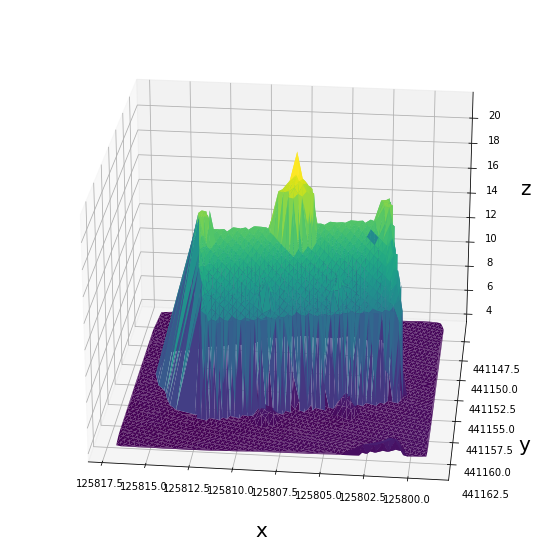

In [19]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.ticklabel_format(useOffset=False)

ax.plot_trisurf(points2['X'], points2['Y'], points2['Z'],cmap='viridis')

ax.set_xlabel('x', fontsize=20, labelpad=20)
ax.set_ylabel('y', fontsize=20, labelpad=35)
ax.set_zlabel('z', fontsize=20, labelpad=25)
ax.view_init(25, 96)
ax.tick_params(axis='y', pad=20)
ax.tick_params(axis='z', pad=10)
plt.show()

# Next

In this tutorial you converted LiDAR point cloud to a sparse array and explored and visualised a point cloud. The following tutorials ... 

### LICENSE

The MIT License

Copyright (c) 2021 TileDB, Inc.